In [2]:
# Load in packages
import numpy as np
from numpy.linalg import cholesky, LinAlgError
import matplotlib as plt 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
from scipy.special import logsumexp, gammaln
from scipy.optimize import minimize
import statsmodels.api as sm

$\textbf{Problem 1.}$

(a) To find the log-likelihood, we will start by formulating the likelihood as the sum of the piecewise density by using indicators. First we define the indicator function
$$ \text{I}(X_i =0) = \begin{cases} 1 \hspace{.1cm} \text{if} \hspace{.1cm} X_i = 0, \hspace{.1cm} \text{and}\\
0 \hspace{.1cm} \text{otherwise} \end{cases}$$ 
Now, we can write the likelihood function $L(\underline{X}, \theta) \vcentcolon= \prod_{i=1}^n f_{\lambda,\pi}(x)$ as 
$\begin{align} L(\underline{X}, \theta) &= \prod_{i=1}^n \text{I}(X_i =0)\pi + (1-\pi)\frac{e^{\text{-}\lambda}\lambda^{x_i}}{x_i !}\\
&= \bigg(\pi^{\sum_{i=1}^n \text{I}(X_i = 0)}\bigg)\bigg((1-\pi)^{n - \sum_{i=1}^n \text{I}(X_i =0)} \cdot e^{\text{-}n\lambda}\cdot\lambda^{(\sum_{i=1}^n x_i)} \prod_{i=1}^n \frac{1}{x_i !}\bigg) \\
&= \underbrace{\bigg(\pi^{n_0}(1-\pi)^{n - n_0}\bigg)}_{\text{depends only on} \hspace{.05cm} n_0} \underbrace{\bigg(e^{\text{-}n}\lambda^{(\sum_{i=1}^n x_i)}\bigg)}_{\text{depends only on}\hspace{.05cm} \sum_{i=1}^n x_i} \hspace{.1cm} \times \hspace{.1cm} \underbrace{\bigg(\prod_{i=1}^n\frac{1}{x_i !}\bigg).}_{\text{depends only on data}}
\end{align}$
Therefore, $n_0 = \sum_{i=1}^n \text{I}(X_i =0)$ is a sufficient statistic for $\pi$ by the Fisher-Neymann factorization criterion. Similarly, $\sum_{i=1}^n x_i$ is a sufficient statistic for $\lambda$, and since $g(t) = 1/t$ is injective, we have that $\overline{X} = \frac{1}{b}\sum_{i=1}^n X_i$ is sufficient as well by sufficiency invariance, where $b = n - n_0 \in \mathbb{N}$. Now, in preparation the find the score and Hessian of the log-likelihood, we write the expression for the log-likelihood as follows
$$ \ell(\underline{x},\theta) =\sum_{i=1}^n  \text{I}(X_i = 0)\log (\pi  + (1-\pi)e^{\text{-}\lambda}) + \text{I}(X_i >0)\big(\log(1-\pi)+ x_i\log\lambda -\lambda -\log x_i!\big). $$

In [27]:
# Part 1 a)

fish_count = pd.read_csv('fish.csv')


# Function that computes the log-likelihood of the ZIP distribution and caches the sufficient statistics n0 and Xbar.
# Takes in a vector theta = (lambda, pi) and a set of data. 

def ll_ZIP(theta, data):
    LAMBDA = theta[0]
    PI = np.clip(theta[1], 1e-6, 1-1e-6) 
    n = len(data)
    n0 = sum(data == 0)
    Xbar = sum(data) / (n - n0)
    SS = [n0, Xbar]
    
    l_likelihood = 0
    for x in data:
        if x == 0:
            l_likelihood += logsumexp([np.log(PI), np.log(1 - PI) - LAMBDA])
        else:
            l_likelihood += np.log(1 - PI) + x * np.log(LAMBDA) - LAMBDA - gammaln(x + 1)
    return l_likelihood , SS  


print('(log-likelihood, SS):', ll_ZIP([7, .56], fish_count.loc[:, "count"] ))


(log-likelihood, SS): (-1129.976748114176, [142, 7.62962962962963])


(b) Now, using the expression for the log likelihood above, we will differenitate once with respect to $\theta = (\lambda,\pi)$ to find the score vector, then differentiate once more to find the Hessian matrix. We find that the first derivatives are 
$$ \frac{\partial\ell}{\partial\pi} = \sum_{i=1}^n \text{I}(X_i = 0) \frac{1-e^{\text{-}\lambda}}{\pi +(1-\pi)e^{\text{-}\lambda}} - \text{I}(X_i >0)\frac{1}{1-\pi},$$
and 
$$\frac{\partial\ell}{\partial\lambda} = \sum_{i=1}^n \text{I}(X_i = 0) \frac{\text{-}(1-\pi)e^{\text{-}\lambda}}{\pi + (1-\pi)e^{\text{-}\lambda}} + \text{I}(X_i>0)\big(\frac{x_i}{\lambda}-1\big). $$ 
We can differientiate each of these once more with respect to each of the two parameters to get the $2\times2$ Hessian matrix. We have that
$$ \frac{\partial^2\ell}{\partial\pi^2} = -\sum_{i=1}^n \text{I}(X_i = 0)\frac{(1-e^{\text{-}\lambda})^2}{(\pi + (1-\pi)e^{\text{-}\lambda})^2} - \text{I}(X_i>0)\frac{1}{(1-\pi)^2},$$
and
$$ \frac{\partial^2\ell}{\partial\lambda^2} = -\sum_{i=1}^n \text{I}(X_i = 0)\frac{\pi(1-\pi)e^{\text{-}\lambda}}{(\pi + (1-\pi)e^{\text{-}\lambda})^2} - \text{I}(X_i>0)x_i\lambda^{\text{-}2}.$$
Similarly, we see that the mixed derivatives are
$$ \frac{\partial^2\ell}{\partial\lambda\partial\pi} = \frac{\partial^2\ell}{\partial\pi\partial\lambda} = \sum_{i=1}^n \text{I}(X_i = 0)\frac{e^{\text{-}\lambda}}{(\pi + (1-\pi)e^{\text{-}\lambda})^2}.$$

In [26]:
# Part 1 b) 

# Functions to compute the Score (gradient vector) and Hessian of the log-likelihood (log scale). 
# Each function takes in log(theta)=log([lambda,pi]), the data vector of counts from the Fish csv, and the 
# Sufficient Statistics (SS) cached from the ll_ZIP() function in part 1a).

def score_ZIP(log_theta, data, SS):
    log_LAMBDA, log_PI = log_theta
    LAMBDA = np.exp(log_LAMBDA)
    PI = np.clip(np.exp(log_PI), 1e-6, 1-1e-6)
    n0, Xbar = SS
    n = len(data)

    dL_dlogPI = PI * (n0 * (1 - np.exp(-LAMBDA)) / (PI + (1 - PI) * np.exp(-LAMBDA)) - (n - n0) / (1 - PI))
    dL_dlogLAMBDA = LAMBDA * (n0 * (1 - PI) * np.exp(-LAMBDA) / (PI + (1 - PI) * np.exp(-LAMBDA)) + ((n - n0) * Xbar ) - n)

    return np.array([dL_dlogLAMBDA, dL_dlogPI])

def hessian_ZIP(log_theta, data, SS):
    log_LAMBDA, log_PI = log_theta
    LAMBDA = np.exp(log_LAMBDA)
    PI = np.clip(np.exp(log_PI), 1e-6, 1-1e-6)
    n0, Xbar = SS
    n = len(data)

    d2L_dlogPI2 = PI**2 * (-n0 / (PI + (1 - PI) * np.exp(-LAMBDA))**2 - (n - n0) / (1 - PI)**2)
    d2L_dlogLAMBDA2 = LAMBDA**2 * (-n0 * (1 - PI) * np.exp(-LAMBDA) / (PI + (1 - PI) * np.exp(-LAMBDA)) + (n - n0))
    d2L_dlogLAMBdlogPI = LAMBDA * PI * (n0 * np.exp(-LAMBDA) / (PI + (1 - PI) * np.exp(-LAMBDA))**2)

    return np.array([[d2L_dlogLAMBDA2, d2L_dlogLAMBdlogPI], [d2L_dlogLAMBdlogPI, d2L_dlogPI2]])

(c) Let $\text{H}\in \mathbb{R}^{d\times d},$ denote the Hessian matrix and let $\nabla \ell \in \mathbb{R}^{d}$ denote the score vector of $\ell.$ Let the subscript denote the value at which we are evaluating the function. Then, we can write the general recursion formula for the Newton Raphson method for optimization as follows
$$ x_{k+1} = x_k - \text{H}_{(x=x_k)}^{\text{-}1}\nabla \ell_{(x=x_k)}.$$
In our implementation, we have added a stepsize $\eta = 0.001,$ and have set the number of iterations to 100. The updated general recursion is 
$$ x_{k+1} = x_k - \eta \text{H}_{(x=x_k)}^{\text{-}1}\nabla \ell_{(x=x_k)}.$$
In addition, we add a regularization term of $1\times10^{\text{-}6}$ to the diagonal entries of $\text{H}$ at each step to avoid singularity of the matrix. Singular matrices do not have inverses, and adding a positive value to the diagonal guarantees that the matrix is nonsingular since each row will have a pivot if the diagonals are nonzero. For our starting guess, we use the values $(6,.5)$, which are reasonable given the sufficient stastics $\overline{X}_{i:x_i>0} \approx 7.6$, and given that the number of zeros is approximately half of the total number of counts in the dataset. We choose 6 because it is close to 7 such that it should not have difficultly finding the maximum, but is not so close that we are not able to test the convergence of the method and accuracy of the estimates.

In [68]:
# Part 1 c)

def newtons_method_reg(data, initial_log_theta, num_iterations=100, reg_coeff=1e-2, stepsize=0.001):
    log_theta = initial_log_theta
    for i in range(num_iterations):
        n = len(data)
        n0 = np.sum(data == 0)
        Xbar = np.sum(data) / (n - n0) if n - n0 > 0 else 0
        SS = [n0, Xbar]

        score = score_ZIP(log_theta, data, SS)
        hessian = hessian_ZIP(log_theta, data, SS)

        # Regularize and invert the Hessian matrix in a numerically stable way
        try:
            hessian_reg = hessian + reg_coeff * np.eye(len(log_theta))
            L = cholesky(hessian_reg)
            hessian_inv_score = np.linalg.solve(L.T, np.linalg.solve(L, score))
        except LinAlgError:
            # If Cholesky decomposition fails (not psd), increase the regularization coefficient and retry the update
            reg_coeff *= 3
            continue  

        log_theta = log_theta - stepsize * hessian_inv_score
        
        # Might want to change for different num_iter 
        if i % 10 == 0:
            print("Iteration", i, "log_theta:", log_theta, "theta:", np.exp(log_theta))
        
    return np.exp(log_theta)  

initial_guess = [6, 0.5]
log_initial_guess = np.log(initial_guess)
estimated_theta_reg = newtons_method_reg(fish_count['count'].values, log_initial_guess)
print("Estimated parameters:", estimated_theta_reg)


Iteration 10 log_theta: [ 1.79098789 -0.69323527] theta: [5.99537234 0.49995596]
Iteration 20 log_theta: [ 1.78324732 -0.69411569] theta: [5.94914388 0.49951598]
Iteration 30 log_theta: [ 1.77546136 -0.69499512] theta: [5.90300393 0.49907688]
Iteration 40 log_theta: [ 1.76762965 -0.69587329] theta: [5.85695385 0.4986388 ]
Iteration 50 log_theta: [ 1.75975182 -0.69674994] theta: [5.81099503 0.49820186]
Iteration 60 log_theta: [ 1.75182751 -0.6976248 ] theta: [5.76512889 0.49776619]
Iteration 70 log_theta: [ 1.74385636 -0.69849758] theta: [5.71935684 0.49733194]
Iteration 80 log_theta: [ 1.735838   -0.69936799] theta: [5.67368034 0.49689925]
Iteration 90 log_theta: [ 1.72777206 -0.70023572] theta: [5.62810085 0.49646826]
Estimated parameters: [5.5871635  0.49608196]


(d) Given the new formulation where we have $Z_i \sim \text{Bern}(\pi), X_i|Z_i \sim \text{Po}((1-Z_i)\lambda),$ and $X_i \sim \text{ZIP}(\lambda,\pi),$ we find that the likelihood is just the product of the conditional $X_i|Z_i$ and the marginal of $Z_i$, given that $X_i \perp\!\!\!\!\perp Z_i.$ We have that the complete data likelihood is given by 
\begin{align*} L(\underline{X},\theta) &= \prod_{i=1}^n \mathbb{P}_{\theta}(X_i|Z_i)\mathbb{P}_\theta(Z_i)\\
&= \prod_{i=1}^n \bigg((1-\pi)\frac{\lambda^{X_i}e^{\text{-}\lambda}}{X_i!}\bigg)^{1-Z_i} \cdot (\pi^{Z_i})
\end{align*}
We see this is the correct expression since when $Z_i = 0$, we are left with the Bernoulli probability $\pi$, and when $Z_i=1$, we are left with the Poisson part. Now we take the log to find the complete data log-likelihood as follows
$$ \ell(X, Z, \theta) = \sum_{i=1}^n Z_i \log(\pi) + (1-Z_i)\log(1-\pi) + (1-Z_i)\big(X_i\log\lambda - \lambda - \log X_i)$$
Now, to see the dependence of $Q(\theta,\theta^{(t)})$ on $p_i^{(t)}$, we start by noting that $p_i^{(t)}$ is the expeced value of of the unobserved (latent) variable $Z_i$ given $\theta^{(t)}$ and $X_i=0$. $Z_i$ is an indicator variable, so the expected value of an indicator is just the probability of the event that it is indicating is a success. For $X_i>0$, we need $Z_i=0$ so that we isolate the Poisson part. This also makes intuitive sense, since there cannot be structural zeros where we have already stipulated $X_i>0.$  We have justified that $p_i^{(t)}$ is an expected value, and can see from the form it that it is the Bernoulli probability at step $t$ divided by the sum of the Bernoulli and Poisson probabilities at $t$ given that the fish count $X_t$ is 0. Mathematically, this is represented as 
$$p_i^{(t)} = \frac{\pi^{(t)}}{\pi^{(t)} + (1-\pi^{(t)})e^{\text{-}\lambda^{(t)}}}\text{I}(X_i=0),$$
where the indicator ensures we are only using $p_i^{(t)}$ when $X_i=0,$ matching the definition provided. Now, from the definition of $Q(\theta,\theta^{(t)})$, we can write it explicitly and observe the dependence on $p_i^{(t)}.$ We have that
\begin{align*} Q(\theta,\theta^{(t)}) &\vcentcolon= \mathbb{E}_{Z_t|X_t;\theta^{(t)}} [\ell(X_t,Z_t;\theta)]\\
&= \sum_{i=1}^n \mathbb{E}[Z_i|X_i;\theta^{(t)}]\log\pi + \big(1- \mathbb{E}[Z_i|X_i;\theta^{(t)}]\big) \log(1-\pi) + \big(1- \mathbb{E}[Z_i|X_i;\theta^{(t)}]\big)\big(X_i\log\lambda - \lambda - \log(X_i!)\big)\\
&= \bigg\{\text{I}(X_i=0) \sum_{i=1}^n p_i^{(t)}\log\pi + (1-p_i^{(t)})\log(1-\pi)\bigg\} + \bigg\{\text{I}(X_i>0)\sum_{i=1}^n \log(1-\pi) + X_i\log\lambda - \lambda - \log(X_i!)\bigg\},
\end{align*}
and we simply observe that since $Q(\theta,\theta^{(t)}) $ can be written explicitly in terms of $p_i^{(t)}$, it depends on it at each step $t.$ 




(e) The updated variables at step $t+1$, denoted $\pi^{(t+1)}$ and $\lambda^{(t+1)},$ are essentially estimators that use the most recent parameter estimates. So, setting the derivative of the conditional expectation to zero then solving for the argument that gives the maximum value essentially maximizes the likelihood of the parameters themselves given the data. To find the update rules for the parameters $\pi$ and $\lambda,$ we will differentiate $Q$ with respect to each paramter, set each equal to zero, then solve for the parameter we differentiated with respect to.  We differentiate $Q$ and find that
$$ \frac{\partial Q}{\partial\pi} = \sum_{i} \frac{\partial}{\partial\pi}\bigg[ p_i^{(t)}\log\pi + (1-p_i^{(t)})\log(1-\pi)\bigg] = \sum_i \frac{p_i^{(t)}}{\pi}-\frac{1-p_i^{(t)}}{1-\pi} =0.$$
Now, setting the partial equal to $0$ and solving for $\pi$ gives
\begin{align*} \sum_i \frac{p_i^{(t)}}{\pi} - \frac{1- p_i^{(t)} }{1-\pi} &= 0\\
\frac{(1-\pi) \sum_i p_i^{(t)}}{(1-\pi)\pi} - \frac{\pi \sum_i (1-p_i^{(t)})}{(1-\pi)\pi} &=0\\
(1-\pi) \sum_i p_i^{(t)} - \pi \sum_i (1- p_i^{(t)})&=0\\
(1-\pi) \sum_i p_i^{(t)} -n\pi + \pi \sum_i p_i^{(t)} &=0\\
-n\pi +  \sum_i p_i^{(t)}&= 0 \\
\pi^{(t+1)} &= \frac{ \sum_i p_i^{(t)}}{n}, \end{align*}
as desired.
Now lets differentiate $Q$ with respect to $\lambda.$ Note that we can rewrite the indicator with the complement of $p_i^{(t)},$ or the complement of the probability of the event that we draw from the Bernoulli part when $X_i =0$. The complement in this case can be seen more simply as the probability we draw from the Poisson part. We have
$$ \frac{\partial Q}{\partial\lambda} = (1-p_i^{(t)})\sum_{i=1}^n \frac{\partial}{\partial\lambda}\big[X_i\log\lambda - \lambda\big] = (1-p_i^{(t)})\sum_{i=1}^n \bigg[\frac{X_i}{\lambda}-1\bigg] .$$
To find our update rule, as before, we will set $\frac{\partial Q}{\partial\lambda} = 0$ and solve for $\lambda.$ We see that
\begin{align*}  0 &= (1-p_i^{(t)})\sum_{i=1}^n \bigg[\frac{X_i}{\lambda} - 1\bigg] \\
0 &= \sum_{i=1}^n \frac{X_i(1-p_i^{(t)})}{\lambda} - (1-p_i^{(t)}) \\
0 &= \frac{\sum_{i=1}^n X_i(1-p_i^{(t)})}{\lambda} - \sum_{i=1}^n (1-p_i^{(t)}) \\
\sum_{i=1}^n (1-p_i^{(t)}) &= \frac{\sum_{i=1}^n X_i(1-p_i^{(t)})}{\lambda} \\
\lambda \sum_{i=1}^n (1-p_i^{(t)}) &= \sum_{i=1}^n X_i(1-p_i^{(t)})\\
\lambda^{(t+1)} &= \frac{\sum_{i=1}^n X_i(1-p_i^{(t)})}{\sum_{i=1}^n (1-p_i^{(t)}) },\end{align*}
which is the given update rule. We will now implement these update rules to create an EM algorithm to estimate the ZIP parameters.

In [64]:
# Part 1 f)

def EM_ZIP(EM_guess, data, tol=1e-6, max_iter=100):
    lambda_ = EM_guess[0]  
    pi_ =  EM_guess[1]  

    for iteration in range(max_iter):
        # E-step
        p_i = (pi_ / (pi_ + (1 - pi_) * np.exp(-lambda_))) * (data == 0)
        
        # M-step
        pi_new = np.mean(p_i)
        lambda_new = np.sum(data * (1 - p_i)) / np.sum(1 - p_i)
        
        # Check for convergence
        if np.abs(lambda_new - lambda_) < tol and np.abs(pi_new - pi_) < tol:
            break
        
        lambda_, pi_ = lambda_new, pi_new
    
    return lambda_, pi_, iteration +1

EM_guess = [6,0.5]
EM_results= EM_ZIP(EM_guess, fish_count['count'].values)
print('theta, iterations:', EM_results)

theta, iterations: (7.625908581612407, 0.5677892063973443, 4)


(f) From Newton's Method with a starting guess of $\theta^{(k)} = (6, 0.5)$, a stepsize of $\eta=0.001$, and iterations $=100$, we find $\hat{\theta}_{\text{NR}} = (\hat{\lambda}_{\text{NR}}, \hat{\pi}_{\text{NR}}) \approx ( 5.6, 0.49)$. This is a decent approximation for the true parameters, but not as close as the output of the EM procedure. Considering that differentiating once to find the score and twice to find the Hessian was time consuming and somewhat tedious, this poses an advantage to using EM over Newton's. In addition, we observe that Newton's Method is sensitive to choices of hyperparameters and initial guess. From the EM method with the same initial guess, we find $\hat{\theta}_{\text{EM}} = (\hat{\lambda}_{\text{EM}}, \hat{\pi}_{\text{EM}}) \approx (7.6, 0.57),$ which is closer to the true $\theta$ than the result from Newton's Method. In addition, for $\eta = 0.001$, Newton's method was able to achieve relatively low error estimates in 100 iterations, compared to just four iterations of the EM procedure. We conclude that for the problem of ZIP estimation posed, the EM procedure is more efficient computationally, more accurate, and easier to implement than Newton's Method. 

$\text{Problem 2.}$

(a) Given that $Z_t \sim \text{Gamma}(\frac{\nu}{2}, \frac{\nu}{2})$ and $X_t|Z_t \sim \mathcal{N}(\mu_t, \sigma^2 /Z_t),$ we have that the densities can be written as
$$ f(Z_t;\theta) = \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)} Z_t^{\frac{\nu}{2}-1} e^{\text{-}\frac{\nu}{2}Z_t}$$
and
$$ F(X_t|Z_t ; \theta) = \frac{\sqrt{Z_t}}{\sigma\sqrt{2\pi}}\exp\bigg(\text{-}\frac{Z_t(X_t - \mu_t)^2}{2\sigma^2}\bigg).$$
By definition of $Q(\theta,\theta^{(t)})$, we have that
$$Q(\theta,\theta^{(t)}) \vcentcolon= \mathbb{E}_{Z_t|X_t;\theta^{(t)}}\big[ \ell(X_t, Z_t;\theta^{(t)})\big],$$
where $\ell(X_t, Z_t;\theta^{(t)})$ represents the complete data log-likelihood. We can write the joint density as the product of the conditional and marginal densities, then take the log of the product of $i=1,...,n$ iid joint densities to get the complete data log-likelihood. Therefore, the complete data log-likelihood is given by
\begin{align*}
\ell(X_t, Z_t;\theta^{(t)}) &= \sum_{t=1}^{n} \log f(X_t, Z_t;\theta^{(t)})\\
&=  \sum_{t=1}^{T} \log f(X_t| Z_t;\theta^{(t)})\cdot f(Z_t;\theta^{(t)})\\
&= \sum_{t=1}^{n} \log\bigg(\frac{\sqrt{Z_t}}{\sigma\sqrt{2\pi}}\exp\bigg(\text{-}\frac{Z_t(X_t - \mu_t)^2}{2\sigma^2}\bigg) \cdot \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)} Z_t^{\frac{\nu}{2}-1} e^{\text{-}\frac{\nu}{2}Z_t}   \bigg)
\end{align*}
Now, we will show that $Q(\theta,\theta^{(t)})$ depends only on $\theta$ via $\mathbb{E}(Z_t|X_t;\theta^{(k)}).$ Starting with the definition of $Q(\theta,\theta^{(t)})$, we can see it can be rewritten as follows 
\begin{align*} Q(\theta,\theta^{(k)}) &= \mathbb{E}_{Z_k|X_k;\theta^{(k)}}\big[ \ell(X_t, Z_t;\theta)\big] \\
&= \mathbb{E}_{Z_k|X_k;\theta^{(k)}}\bigg[ \sum_{t=1}^{nT} \log f(X_t, Z_t;\theta)\bigg]\\
&= \sum_{t=1}^{n}\mathbb{E}_{Z_k|X_k;\theta^{(k)}}\big[ \log f(X_t, Z_t;\theta)\big] \\
&= \sum_{t=1}^{n}\mathbb{E}_{Z_k|X_k;\theta^{(k)}}\big[ \log f(X_t| Z_t;\theta)\cdot f(Z_t;\theta)\big] \\
&= \sum_{t=1}^{n}\mathbb{E}_{Z_k|X_k;\theta^{(k)}}\big[ \log f(X_t| Z_t;\theta) + \log f(Z_t;\theta)\big] \\
&= \sum_{t=1}^{n}\mathbb{E}_{Z_k|X_k;\theta^{(k)}}\big[ \log f(X_t| Z_t;\theta)] + \mathbb{E}_{Z_k|X_k;\theta^{(k)}}\big[\log f(Z_t;\nu)\big] \\
&= \sum_{t=1}^{n} \frac{\text{-}1}{2} \log(2\pi\sigma^2) - \frac{1}{2}\mathbb{E}_{Z_t|X_t;\theta^{(k)}}\bigg[\frac{(X_t-\mu_t)^2}{\sigma^2 Z_t}\bigg] + \mathbb{E}[\log Z_t]   \\
&= \sum_{t=1}^{n} \frac{\text{-}1}{2} \log(2\pi\sigma^2) - w_t^{(k)}\frac{(X_t-\mu_t)^2}{\sigma^2 Z_t} + \mathbb{E}[\log Z_t]\\
&\overset{\text{C}}{=}\frac{\text{-}n}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{t=1}^n
(X_t-\mu_t)^2 w_t^{(k)},
\end{align*}
where the C over the equals sign means they are equal up to a constant. Now, we observe from above that $Q(\theta,\theta^{(t)})$ depends only on $\theta$ via $w_t^{(k)}=\mathbb{E}(Z_t|X_t;\theta^{(k)}).$ Note the $\pi$ here is not a probability but the one used as a normalizing constant in the Guassian density (3.14...). 

(b) To show the desired result, we will simply apply Bayes' rule and simplify up to a constant term. We have that the conditional density of $Z_t|X_t;\theta^{(k)}$ can be written as
\begin{align*} f(Z_t|X_t;\theta^{(k)}) &= \frac{f(X_t|Z_t;\theta^{(k)})f(Z_t;\theta^{(k)})}{f(X_t;\theta^{(k)})}\\
&\propto f(X_t|Z_t;\theta^{(k)})f(Z_t;\theta^{(k)}) \\
&\propto \bigg\{ \frac{Z_t^{1/2}}{\sigma^{(k)^2}\sqrt{2\pi}}\exp\bigg(\text{-}\frac{Z_t(X_t-\mu_t^{(k)})^2}{2\sigma^{(k)^2}} \bigg) \bigg\}\times \bigg\{  \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)}Z_t^{\frac{\nu}{2} - 1} e^{\text{-}\frac{\nu Z_t}{2}}\bigg\} \\
&\propto Z_t^{\frac{1}{2}}Z_t^{\frac{\nu}{2}-1}\exp\bigg( \text{-}Z_t\big( \frac{(X_t-\mu_t^{(k)})^2}{\sigma^{(k)^2}2}+\frac{\nu}{2}  \big)\bigg) \\
&\propto Z_t^{(\frac{\nu}{2}+\frac{1}{2}) - 1} \exp\bigg( \text{-}Z_t\big(\frac{\nu}{2} + \frac{(X_t-\mu_t^{(k)})^2}{2\sigma^{(k)^2}}  \big)\bigg), \end{align*}
and we recognize that $f(Z_t|X_t;\theta^{(k)})$ is proportional to a Gamma distribution. Therefore, we can conclude from observation that 
$$ Z_t|X_t;\theta^{(k)} \overset{iid}{\sim}\Gamma\bigg(\frac{\nu}{2} + \frac{1}{2}, \frac{\nu}{2} + \frac{(X_t-\mu_t^{(k)})^2}{2\sigma^{(k)^2}}\bigg).$$
Given that $w_t^{(k)} \vcentcolon=\mathbb{E}[Z_t|X_t;\theta^{(k)}],$ we can find this expectation easily now that we have the distribution of $Z_t|X_t;\theta^{(k)}.$ We know that for $Y\sim\Gamma(\alpha,\beta), \mathbb{E}[Y] = \frac{\alpha}{\beta}.$ So, dividing the shape of $Z_t|X_t;\theta^{(k)}$ by the scale of $Z_t|X_t;\theta^{(k)}$, we find that 
\begin{align*}
w_t^{(k)} &= \mathbb{E}[Z_t|X_t; \theta^{(k)}]\\
&= \frac{ \frac{\nu}{2} + \frac{1}{2} }{\frac{\nu}{2} + \frac{(X_t -\mu_t^{(k)})^2}{2\sigma^{(k)^2}}}\\
&= \frac{\nu + 1}{\nu + \frac{(X_t -\mu_t^{(k)})^2}{\sigma^{(k)^2}}}.\end{align*}
Since $w_t^{(k)}$ is just a fraction of parameters and one random variable, we notice that it achieves its maximum when the denominator is the smallest, which occures exactly when $X_t = \mu_t^{(k)}$. In this case, we can rewrite the expectation as
$$ w_t^{(k)} = \frac{\nu + 1}{\nu + 0} = \frac{\nu+1}{\nu}.$$


(c) Now, we will show again the equation for $Q$ in terms of $w_t^{(k)}.$ Up to a constant, it is 
$$ Q(\theta, \theta^{(k)}) \overset{\text{C}}{=}\frac{\text{-}n}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{t=1}^n (X_t-\mu_t)^2 w_t^{(k)} .$$
The idea behind the M-step is to find the parameters that maximize $Q$. Looking at the second term, we see that it is in a similar form to a weighted least squares cost function, recalling that weighted least squares takes the product of weights with the sum of squares error term, where the error is precisely $(X_t - \mu_t^{(k)}).$ Here, we see that the weights $w_t^{(k)}$ are the expected value of the conditional distribution $Z_t|X_T;\theta^{(k)}\sim\Gamma$, or the precision of the obervation. So, the weighted least squares regression is done by minimizing $\sum_{t=1}^n (X_t-\mu_t)^2.$ This is the same thing as running a linear regression model where the predictors are assigned weights depending on their variance. For this problem we have that the mean is expressed as a weighted linear combination of the predictors. So, we conclude that optimizing $Q$ in the M-step is analogous to optimizing the sum of squares in a more traditional regression model. 


In [37]:
# Part 2 d)

# Read in wind data and configure parameters

nu = 1
T = 12
start_params = np.array([10, 3, 0])  # [Intercept, Amplitude, Phase]

wind_data  = pd.read_csv('wind.csv')
X_t = wind_data['speed'].values
t = wind_data['month_seq'].values

def em_wind(X_t, start_params, nu, max_iter=100, tol=1e-6):
    n = len(X_t) 
    params = start_params.copy()
    sigma2 = np.var(X_t)
    
    for iteration in range(max_iter):
        # E-step: calculate mu_t, residuals, w_t for maximization.
        mu_t = params[0] + params[1] * np.sin(2 * np.pi * t / T + params[2])
        residuals = X_t - mu_t
        w_t = (nu + 1) / (nu + (residuals**2 / sigma2))
        
        # M-step: Maximize conditional expectation by running the WLS model.
        X_design = np.column_stack((np.ones(n), np.sin(2 * np.pi * t / T), np.cos(2 * np.pi * t / T))) # Almost like cbind(), useful for making the design matrix
        wls_model = sm.WLS(X_t, X_design, weights=w_t) 
        results = wls_model.fit() 
        
        new_params = results.params # pull parameters from model object
        new_sigma2 = np.sum(w_t * residuals**2) / np.sum(w_t) # weighted sum of squares of residuals 
        
        # Check for convergence. Perhaps a last 50% iterate average method could be employed here?
        if np.linalg.norm(new_params - params) < tol and np.abs(new_sigma2 - sigma2) < tol:
            break
        
        params, sigma2 = new_params, new_sigma2
        
    return params, sigma2, iteration

# Run the EM algorithm
final_params, final_sigma2, iterations = em_wind(X_t, start_params, nu)

print('[Intercept, Amplitude, Phase] sigma^2, num-iter =', final_params, str(final_sigma2) + ',', iterations)


[Intercept, Amplitude, Phase] sigma^2, num-iter = [9.63915759 0.72809953 1.06073413] 1.6568746829741143, 23


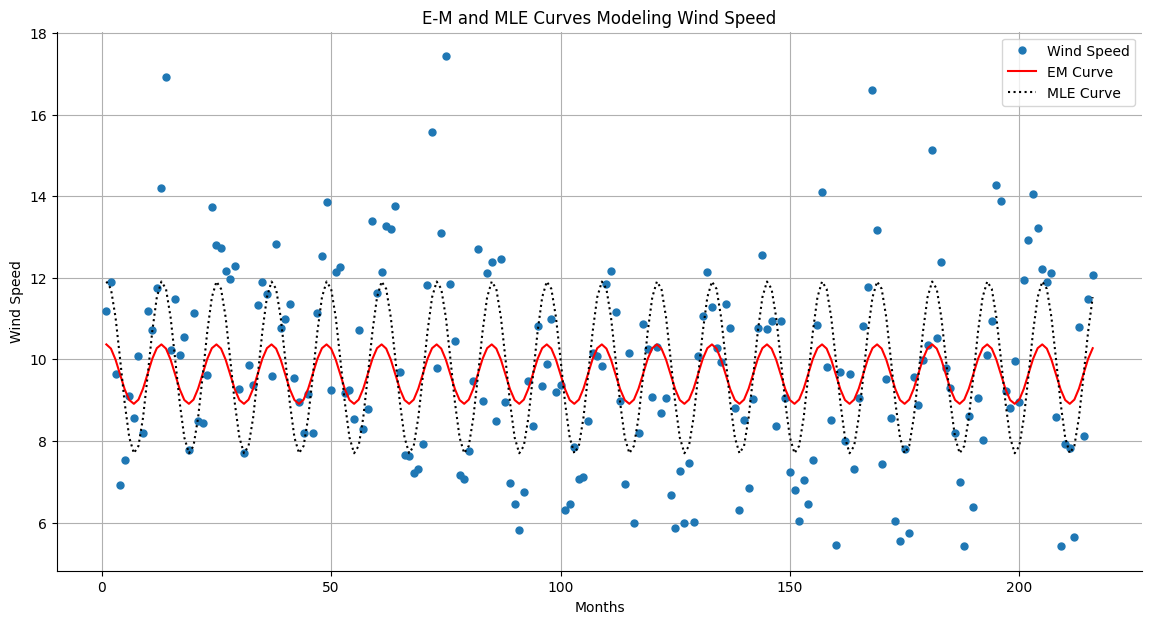

In [38]:
# Part 1 d) 

# Plot the curves

EM_fitted = final_params[0] + final_params[1] * np.sin(2 * np.pi * t / T + final_params[2])
ols_model = sm.OLS(X_t, sm.add_constant(np.column_stack((np.sin(2 * np.pi * t / T), np.cos(2 * np.pi * t / T)))))
ols_results = ols_model.fit()
mle_fitted = ols_results.predict(sm.add_constant(np.column_stack((np.sin(2 * np.pi * t / T), np.cos(2 * np.pi * t / T)))))

plt.figure(figsize=(14, 7))
plt.plot(t, X_t, 'o', label='Wind Speed', markersize=5)
plt.plot(t, EM_fitted, label='EM Curve', color='red')
plt.plot(t, mle_fitted, label='MLE Curve', color='black', linestyle='dotted')
plt.title('E-M and MLE Curves Modeling Wind Speed')
plt.xlabel('Months')
plt.ylabel('Wind Speed')
plt.legend()
plt.grid(True)
sns.despine()
plt.show()

(d) We see that the EM fitted curve has significantly smaller amplitude than the MLE fitted curve. This is directly caused by the t-distributed data assumption. In the case of $\nu=1,$ the t-distribution reduces to a $\text{Cauchy}(0,1)$ distribution, both of which are known to have undefined variance. Compared to t-distributions with $\nu>2,$ where the variance is given by $\frac{\nu}{\nu-2},$ the $\text{Cauchy}(0,1)$  and $t_1$ distributions assign the highest probability to extreme values; they are more heavy-tailed than the t distributions with larger degrees of freedom. Since they assign higher probabilities to the tails, we expect the model to be more robust to outliers/points far from the mean, resulting in a narrower curve in this case (smaller amplitude). This is exactly the behavior we observe in the figure above. 

Sources: 

Simchowitz, M. (2013). Zero-Inflated Poisson Factorization for Recommendation Systems. Junior Independent Work, Princetion Department of Mathematics. 